#### 1. Load in data

In [1]:
# load libraries
import os
import shutil
import tarfile
import urllib.request
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf

In [2]:
import platform

# Check operating system
is_macos = platform.system() == 'Darwin'

if is_macos:
    # For MacOS, use TensorFlow backend
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    import tensorflow as tf
    print("Using TensorFlow backend on MacOS")
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
else:
    # For other OS, use PyTorch backend
    os.environ['KERAS_BACKEND'] = 'torch'
    import torch
    print("Using PyTorch backend")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cuda


In [3]:
# import libraries for downloading the data

import os
import glob
import urllib.request
import tarfile

# to make google colab compatible
DATA_DIR = "/content/data" # where all downloaded data will go

# where folder containing images subfolders will go
IMAGES_ROOT = os.path.join(DATA_DIR, "Images")

# where folder of annotations will go
ANNOT_ROOT  = os.path.join(DATA_DIR, "Annotation")

# create the directory if it doesn't exist yet
os.makedirs(DATA_DIR, exist_ok=True)

# download the images and annotate tars
IMAGES_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
ANNOT_URL  = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"

# where to save image tar file into images folder
IMAGE_TAR_PATH = os.path.join(DATA_DIR, "images.tar")

# where to save annotation file into annotation folder
ANNOT_TAR_PATH = os.path.join(DATA_DIR, "annotation.tar")

# function to download the file
def download(url, path):
    if os.path.exists(path):
        print(f"{path} already exists, skipping download.")
        return
    print(f"Downloading {url} ...")
    urllib.request.urlretrieve(url, path)
    print("Done!\n")
# download images if not already downloaded
download(IMAGES_URL, IMAGE_TAR_PATH)
# download annotations if not already downloaded
download(ANNOT_URL, ANNOT_TAR_PATH)

# function to extarct the tar files that were downloaded
def extract(tar_path, extract_to):
    print(f"Extracting {tar_path} ...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(extract_to)
    print("Done!\n")
# extracts the data if it wasn't extracted already
extract(IMAGE_TAR_PATH, DATA_DIR)
extract(ANNOT_TAR_PATH, DATA_DIR)

# to sort the breed folders
if not os.path.exists(IMAGES_ROOT):
    raise FileNotFoundError(f"{IMAGES_ROOT} not found. Check extraction paths.")

# sort the breeds alphabetically
breeds = sorted(os.listdir(IMAGES_ROOT))

# prints number of breeds
print("Number of breeds:", len(breeds))
# prints the first 10 breed names
print("First 10 breeds:", breeds[:10], "\n")

# Mapping from breed to index based on sorted order
class_to_idx = {breed: idx for idx, breed in enumerate(breeds)}

# to pair images with annotations folders properly

# lists to storey images and labels
images = []
labels = []

for breed in breeds: # to loop through each breed folder
    breed_img_dir   = os.path.join(IMAGES_ROOT, breed) # path for each image folder
    breed_annot_dir = os.path.join(ANNOT_ROOT, breed) # path for eah annotation folder

     # to list all the images for breed at the moment
    image_files = glob.glob(os.path.join(breed_img_dir, "*.jpg"))

    # for each file, extract the filename
    for img_path in image_files:
        base = os.path.splitext(os.path.basename(img_path))[0]

        # to check that annotation folder exists (latest tar format)
        annot_folder = os.path.join(breed_annot_dir, base)
        if not os.path.exists(annot_folder):
            print("Missing annotation for:", img_path)
            continue # if not missing annotation proceeds with a warning
        # if annotation, append to images and labels properly
        images.append(img_path)
        labels.append(class_to_idx[breed])

print("Total usable images:", len(images))

# an example entry
if len(images) > 0:
    print("\nExample image path:", images[0])
    print("Label index:", labels[0])
    print("Breed:", breeds[labels[0]])
else:
    print("No images were successfully paired. Check extraction paths.")


Done!

Done!

Extracting /content/data/images.tar ...


/tmp/ipython-input-3578446810.py:47: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_to)


Done!

Extracting /content/data/annotation.tar ...
Done!

Number of breeds: 120
First 10 breeds: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound'] 

Total usable images: 20580

Example image path: /content/data/Images/n02085620-Chihuahua/n02085620_712.jpg
Label index: 0
Breed: n02085620-Chihuahua


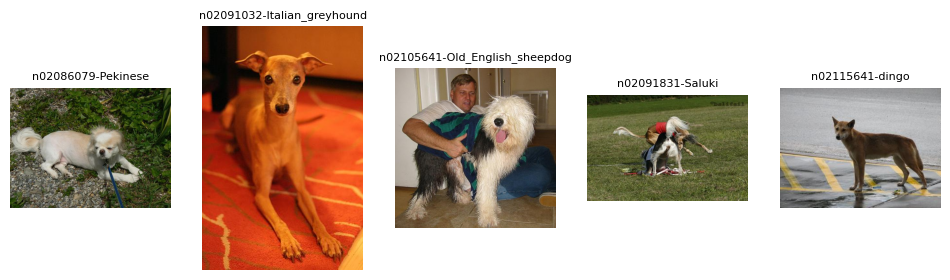

In [4]:
# code to check output of labels
import matplotlib.pyplot as plt
# import numpy to
import numpy as np
import random
from PIL import Image

# sample 5 images randomly and print image and label
sample_indices = random.sample(range(len(images)), 5)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_indices):
    img = Image.open(images[idx])
    label = labels[idx]
    breed_name = breeds[label]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(breed_name, fontsize=8)
    plt.axis('off')
plt.show()


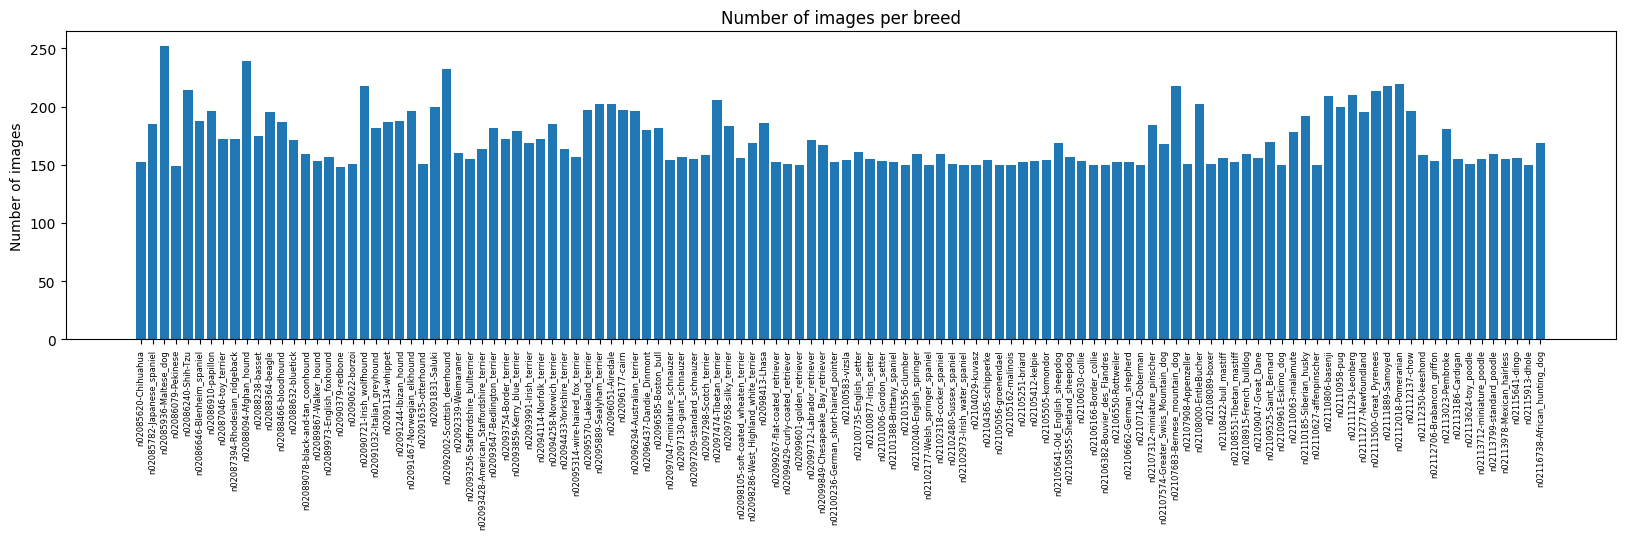

In [5]:
# see distribution of current coutns per breed / class

# get counts for each breeds
counts = [labels.count(i) for i in range(len(breeds))]

# plotting
plt.figure(figsize=(20,4))
plt.bar(range(len(breeds)), counts)
plt.xticks(range(len(breeds)), breeds, rotation=90, fontsize=6)
plt.ylabel("Number of images")
plt.title("Number of images per breed")
plt.show()

In [6]:
# to ensure there are 120 labels used
unique_labels = set(labels)
print("Number of unique labels:", len(unique_labels))
assert len(unique_labels) == len(breeds)
# assertion works and is good

Number of unique labels: 120


In [7]:
# check a breed
  # do chiuahua since it was given in one of the ouput above
breed_to_check = "n02085620-Chihuahua"
breed_idx = class_to_idx[breed_to_check]

# get all images with this label
breed_images = [img for img, lbl in zip(images, labels) if lbl == breed_idx]

print(f"Number of images labeled {breed_to_check}: {len(breed_images)}")
print("First 5 image paths:", breed_images[:5])


Number of images labeled n02085620-Chihuahua: 152
First 5 image paths: ['/content/data/Images/n02085620-Chihuahua/n02085620_712.jpg', '/content/data/Images/n02085620-Chihuahua/n02085620_4919.jpg', '/content/data/Images/n02085620-Chihuahua/n02085620_10131.jpg', '/content/data/Images/n02085620-Chihuahua/n02085620_4602.jpg', '/content/data/Images/n02085620-Chihuahua/n02085620_4572.jpg']


In [8]:
# Decrease to 20 most frequently occurring breeds

breed_counts = []

for breed in os.listdir(IMAGES_ROOT):
    breed_path = os.path.join(IMAGES_ROOT, breed)

    # count jpg files
    n_images = sum(
        f.lower().endswith(".jpg")
        for f in os.listdir(breed_path)
    )

    breed_counts.append((breed, n_images))

# sort by freq (desc)
breed_counts.sort(key=lambda x: x[1], reverse=True)

# select top 20
selected_breeds = [breed for breed, count in breed_counts[:20]]

print("Selected breeds (top 20):")
print(selected_breeds)

# filter
breeds = selected_breeds

Selected breeds (top 20):
['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02090721-Irish_wolfhound', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg', 'n02110806-basenji', 'n02097474-Tibetan_terrier', 'n02095889-Sealyham_terrier', 'n02108000-EntleBucher', 'n02096051-Airedale', 'n02091831-Saluki', 'n02110958-pug', 'n02096177-cairn', 'n02095570-Lakeland_terrier', 'n02086910-papillon']


#### 2. Conduct Data Splits

In [9]:
# import progress bar
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split


OUTPUT_DIR = os.path.join(DATA_DIR, "data_splits")
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_dir = os.path.join(OUTPUT_DIR, "train")
val_dir = os.path.join(OUTPUT_DIR, "val")
test_dir = os.path.join(OUTPUT_DIR, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# # need to sort breeds
# breeds = sorted(os.listdir(IMAGES_ROOT))


for breed in tqdm(breeds, desc="Splitting breeds"):
    breed_path = os.path.join(IMAGES_ROOT, breed)

    # all image paths for this breed
    image_files = [
        os.path.join(breed_path, f)
        for f in os.listdir(breed_path)
        if f.lower().endswith(".jpg")
    ]

    # create splits now

    # 70% train, 15% val, 15% test for splits
    train_imgs, temp_imgs = train_test_split(
        image_files, test_size=0.30, random_state=42
    )
    val_imgs, test_imgs = train_test_split(
        temp_imgs, test_size=0.50, random_state=42
    )

    # output breed folders
    for split_name, split_imgs in zip(["train", "val", "test"],
                                      [train_imgs, val_imgs, test_imgs]):

        split_breed_folder = os.path.join(OUTPUT_DIR, split_name, breed)
        os.makedirs(split_breed_folder, exist_ok=True)

        # copy images to proper split folder
        for img_path in split_imgs:
            shutil.copy(img_path, split_breed_folder)

print("Dataset split complete!")
print(f"Train directory: {train_dir}")
print(f"Val directory:   {val_dir}")
print(f"Test directory:  {test_dir}")

Splitting breeds: 100%|██████████| 20/20 [00:00<00:00, 31.71it/s]

Dataset split complete!
Train directory: /content/data/data_splits/train
Val directory:   /content/data/data_splits/val
Test directory:  /content/data/data_splits/test


In [10]:
# sanity check for decrease to 20 breeds
for split in ["train", "val", "test"]:
    breeds_in_split = sorted(os.listdir(os.path.join(OUTPUT_DIR, split)))
    print(split, len(breeds_in_split), "breeds")
    print(breeds_in_split)

train 20 breeds
['n02085936-Maltese_dog', 'n02086240-Shih-Tzu', 'n02086910-papillon', 'n02088094-Afghan_hound', 'n02090721-Irish_wolfhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02095570-Lakeland_terrier', 'n02095889-Sealyham_terrier', 'n02096051-Airedale', 'n02096177-cairn', 'n02097474-Tibetan_terrier', 'n02107683-Bernese_mountain_dog', 'n02108000-EntleBucher', 'n02110806-basenji', 'n02110958-pug', 'n02111129-Leonberg', 'n02111500-Great_Pyrenees', 'n02111889-Samoyed', 'n02112018-Pomeranian']
val 20 breeds
['n02085936-Maltese_dog', 'n02086240-Shih-Tzu', 'n02086910-papillon', 'n02088094-Afghan_hound', 'n02090721-Irish_wolfhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02095570-Lakeland_terrier', 'n02095889-Sealyham_terrier', 'n02096051-Airedale', 'n02096177-cairn', 'n02097474-Tibetan_terrier', 'n02107683-Bernese_mountain_dog', 'n02108000-EntleBucher', 'n02110806-basenji', 'n02110958-pug', 'n02111129-Leonberg', 'n02111500-Great_Pyrenees', 'n02111889-Samoye

In [11]:
# to double check the counts per image split
for split in ["train", "val", "test"]:
    total = sum(len(files) for _, _, files in os.walk(os.path.join(OUTPUT_DIR, split)))
    print(split, total)


train 2963
val 637
test 644


In [12]:
# check that the total number of breeds is preseved
print(len(os.listdir(train_dir)), "breeds in train")
print(len(os.listdir(val_dir)),   "breeds in val")
print(len(os.listdir(test_dir)),  "breeds in test")

# all 20 breeds in each split data

20 breeds in train
20 breeds in val
20 breeds in test


#### 3. Convert to TF Dataset for efficiency

In [13]:
# convert to pytorch dataset


import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

#split directories
OUTPUT_DIR = os.path.join(DATA_DIR, "data_splits")
train_dir = os.path.join(OUTPUT_DIR, "train")
val_dir   = os.path.join(OUTPUT_DIR, "val")
test_dir  = os.path.join(OUTPUT_DIR, "test")

# training dataset first
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

# validation dataset now
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# test dataset last
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


Found 2963 files belonging to 20 classes.
Found 637 files belonging to 20 classes.
Found 644 files belonging to 20 classes.


#### 4. Cleaning/Augmentation with Keras

Finding best augmentation steps by trying one at a time and training after each change.

In [14]:
# data augmentation using pytorch
from torchvision import datasets, transforms
from  keras import Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness
from keras.applications.densenet import preprocess_input

# data augmentation

data_augmentation = Sequential([
  RandomFlip("horizontal"), # random horizontal flip
  #RandomRotation(0.2), # random rotations up to 0.20 degrees -- doesn't improve accuracy
  RandomZoom(0.15) #random zoom in/out
  #RandomBrightness(0.2) -- doesn't improve accuracy
])

# 3. Apply augmentation/normalization to datasets

# train gets augmentations
train_ds = train_ds.map(lambda x, y: (preprocess_input(data_augmentation(x, training=True)), y))

# validation and test only normalized
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

# 4. Cache, shuffle, prefetch for performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### 5. Train on Keras DenseNet121 pre-trained model

In [15]:
import keras
from keras import layers, optimizers, models
from keras.applications import DenseNet121

def cnn_base_model():
    # 2. Load the pre-trained EfficientNetB0 model
    base_model = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                include_top=False,
                                weights='imagenet')

    # 3. Set the trainable attribute of the base_model to False to freeze its weights
    base_model.trainable = False

    # 4. Create an Input layer
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # 5. Pass the Input layer through the base_model
    x = base_model(inputs, training=False)

    # 6. Add a GlobalAveragePooling2D layer
    x = layers.GlobalAveragePooling2D()(x)


    # 7. Tunable classifier head -- TUNING BEFORE TRANSFER LEARNING
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # 7. Add a Dropout layer with a rate of 0.2
    #x = layers.Dropout(0.2)(x)

    # 8. Add a Dense layer with 20 units and 'softmax' activation
    outputs = layers.Dense(len(breeds), activation='softmax')(x)

    # 9. Create a new keras.Model
    model = keras.Model(inputs, outputs)

    # 10. Compile the new model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # print summary of model
    model.summary()
    return model

model = cnn_base_model()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,171,796 (27.36 MB)

 Trainable params: 134,036 (523.58 KB)

 Non-trainable params: 7,037,760 (26.85 MB)

#### 6. Training

In [16]:
# early stopping to prevent overfitting
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callback = [EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        factor=0.2,      # decrease LR by 80%
        min_lr=1e-6
    ),
      ModelCheckpoint(
      filepath="best_model.keras",
      save_best_only=True,
      monitor="val_loss"
    )
    ]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callback
)


Epoch 1/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 106s 553ms/step - accuracy: 0.5184 - loss: 1.7554 - val_accuracy: 0.9184 - val_loss: 0.2852 - learning_rate: 0.0010
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.9065 - loss: 0.3266 - val_accuracy: 0.9419 - val_loss: 0.1995 - learning_rate: 0.0010
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9303 - loss: 0.2401 - val_accuracy: 0.9388 - val_loss: 0.1836 - learning_rate: 0.0010
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.9514 - loss: 0.1691 - val_accuracy: 0.9435 - val_loss: 0.1728 - learning_rate: 0.0010
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.9659 - loss: 0.1328 - val_accuracy: 0.9372 - val_loss: 0.1889 - learning_rate: 0.0010
Epoch 6/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9683 - loss: 0.1248 - val_accuracy: 0.9356 - val_loss: 0.1765 - learning_rate: 0.0010
Epoch 7/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9815 - loss: 0.0827 - 

#### 7. Visualize Training Progress

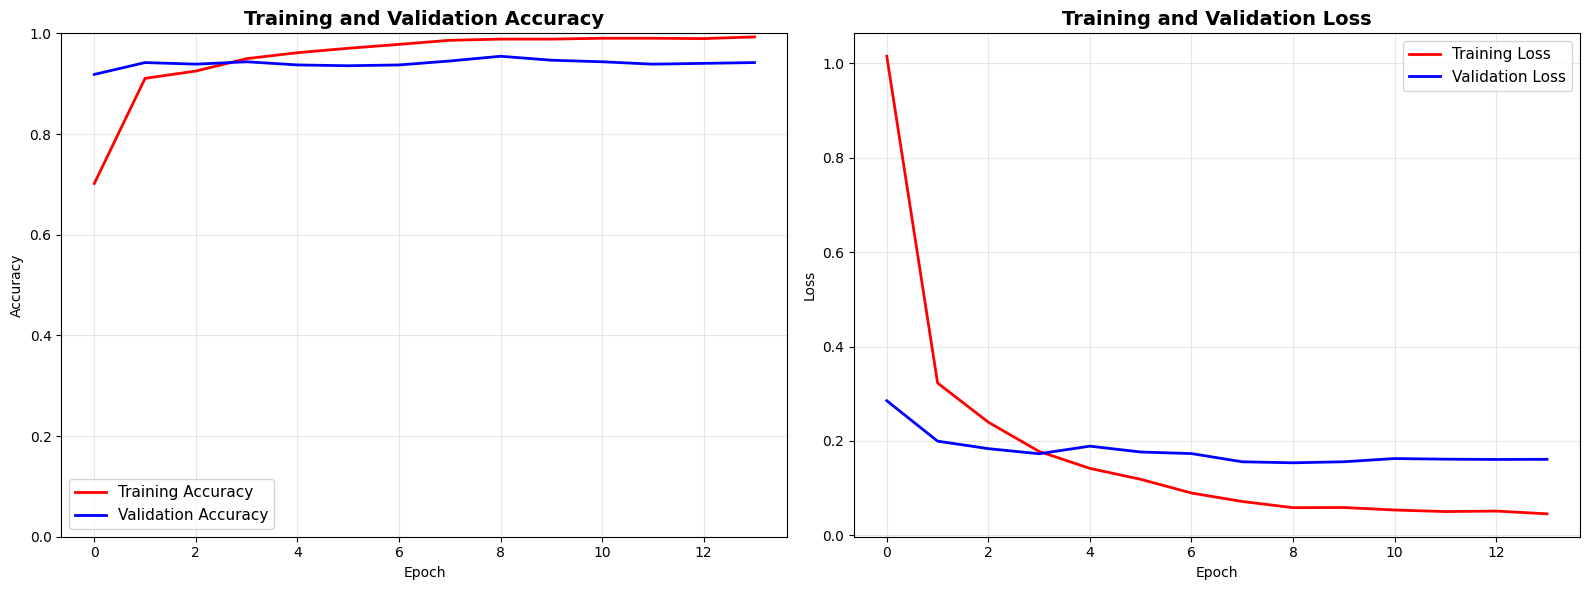


  Training Summary
  Best Training Accuracy:   0.9929
  Best Validation Accuracy: 0.9545
  Final Training Accuracy:  0.9929
  Final Validation Accuracy:0.9419
  Accuracy Gap (final):     0.0510


In [17]:
import matplotlib.pyplot as plt

# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
ax1.legend(fontsize=11); ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Loss plot
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.legend(fontsize=11); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stats printout
print(f"\n{'='*60}")
print("  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f}")
print(f"  Best Validation Accuracy: {max(val_acc):.4f}")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

### 8. Evaluation

Evaluating on test set...
Test Loss: 0.1775
Test Accuracy: 0.9363


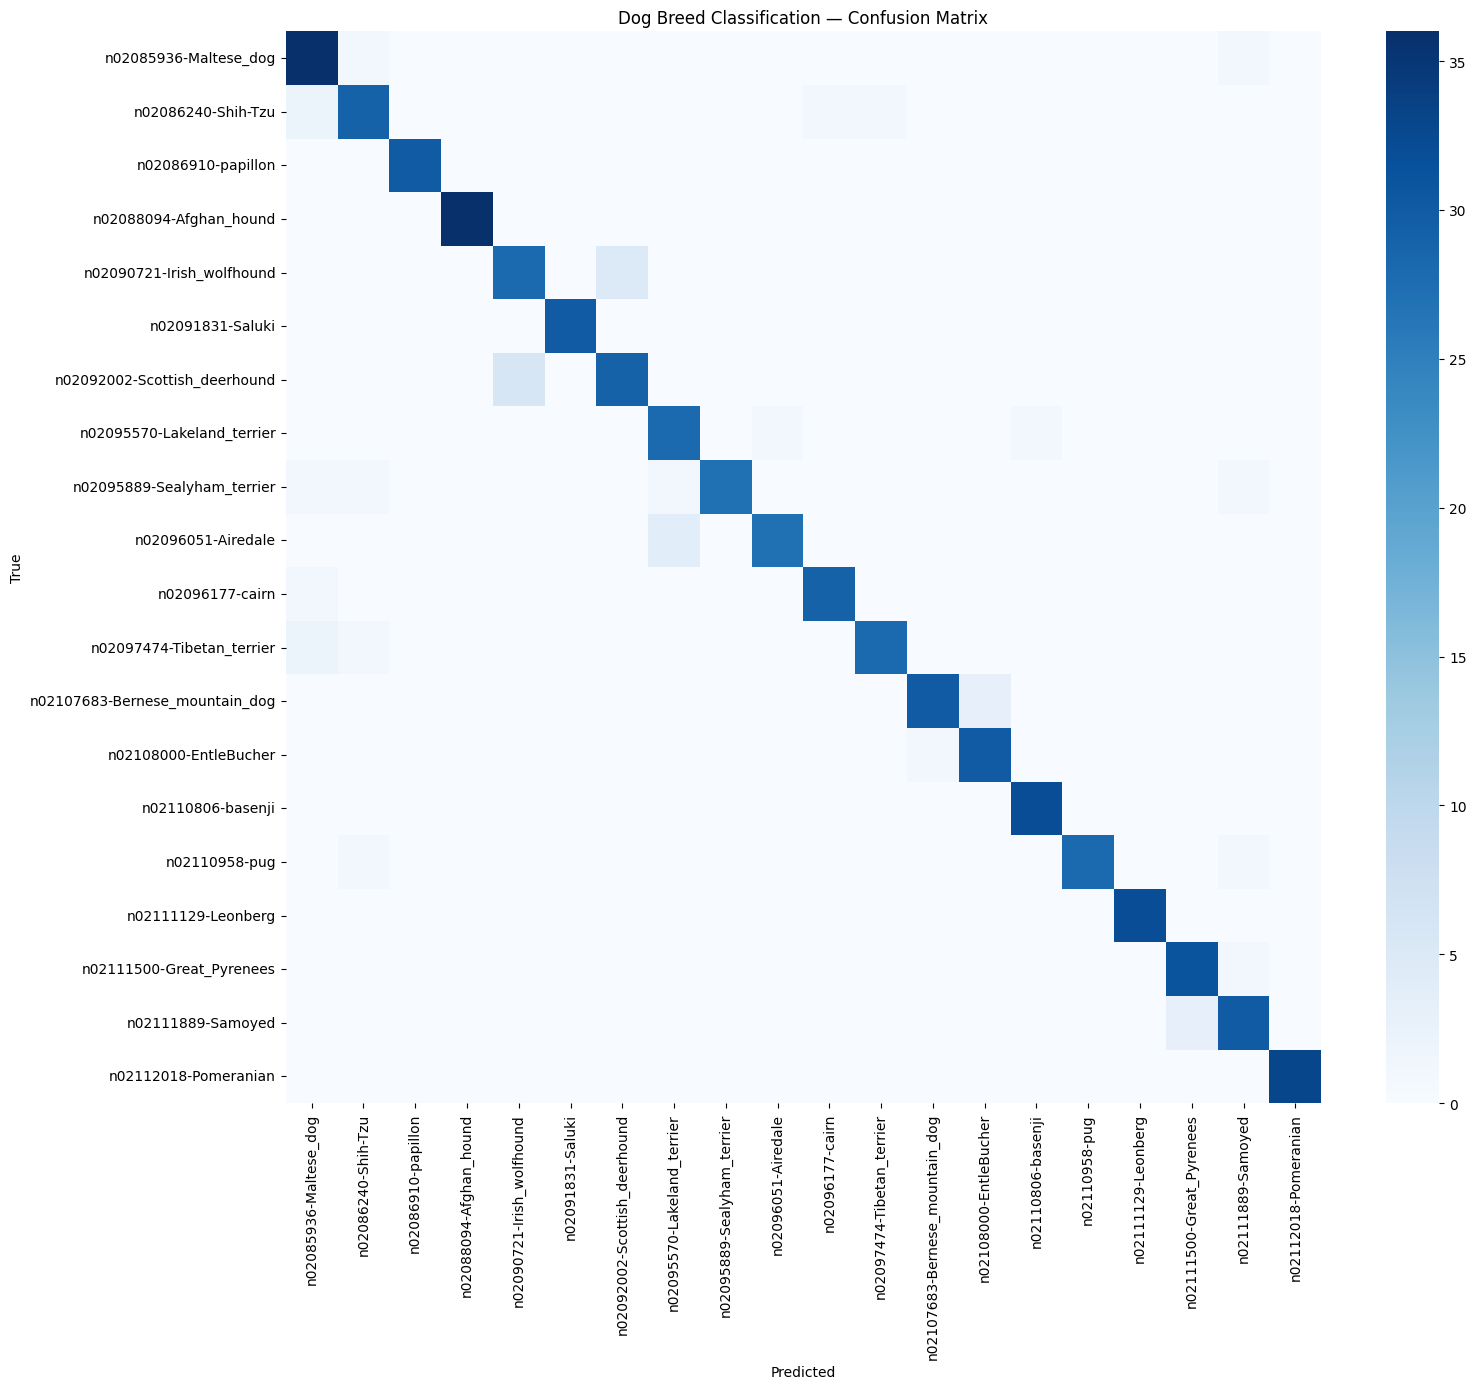

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Manual accuracy
#accuracy = (y_pred == y_true).mean()
#print(f"Manual Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# Retrieve class names directly from the training directory
class_names = sorted(os.listdir(train_dir))

plt.figure(figsize=(16, 14))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Dog Breed Classification — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### 9. Incorporate transfer learning

In [19]:
# 1. Unfreeze the convolutional backbone
base_model = model.layers[1]
base_model.trainable = True

# Optional: unfreeze only the last N layers (safer, less overfitting)
# for layer in base_model.layers[:-50]:
#     layer.trainable = False

print("Number of trainable layers:", len([l for l in model.layers if l.trainable]))


# 2. Re-compile with a very low learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 3. Fine-tune the model (continue from previous training)
fine_tune_epochs = 10

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=history.epoch[-1] + fine_tune_epochs,   # continue from where we left off
    initial_epoch=history.epoch[-1],               # continue training
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True),
               ReduceLROnPlateau(patience=2, factor=0.5)]
)

Number of trainable layers: 7
Epoch 14/23
93/93 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.9361 - loss: 0.2129 - val_accuracy: 0.9309 - val_loss: 0.1767 - learning_rate: 1.0000e-05
Epoch 15/23
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 287ms/step - accuracy: 0.9807 - loss: 0.1010 - val_accuracy: 0.9372 - val_loss: 0.1906 - learning_rate: 1.0000e-05
Epoch 16/23
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - accuracy: 0.9911 - loss: 0.0680 - val_accuracy: 0.9372 - val_loss: 0.1958 - learning_rate: 1.0000e-05
Epoch 17/23
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - accuracy: 0.9937 - loss: 0.0577 - val_accuracy: 0.9356 - val_loss: 0.2052 - learning_rate: 5.0000e-06
Epoch 18/23
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - accuracy: 0.9956 - loss: 0.0461 - val_accuracy: 0.9325 - val_loss: 0.2074 - learning_rate: 5.0000e-06
Epoch 19/23
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 286ms/step - accuracy: 0.9968 - loss: 0.0435 - val_accuracy: 0.9372 - val_loss: 0.2089 - learning_rate: 2.5000e-06


### 10. Visualize fine-tuning training progress

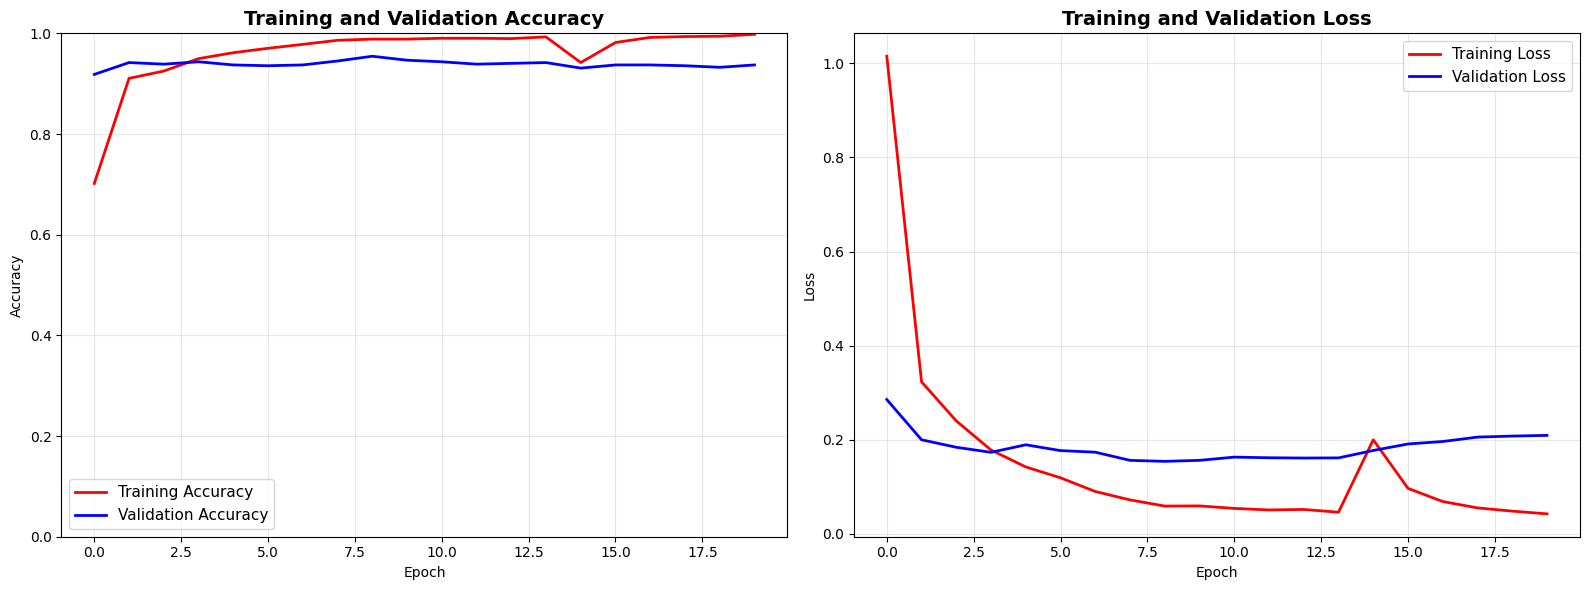


  Training Summary (Including Fine-Tuning)
  Best Training Accuracy:   0.9980
  Best Validation Accuracy: 0.9545
  Final Training Accuracy:  0.9980
  Final Validation Accuracy:0.9372
  Accuracy Gap (final):     0.0608


In [20]:
# Concatenate training curves
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))

# ----- Plots -----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
ax1.legend(fontsize=11); ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Loss plot
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.legend(fontsize=11); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----- Stats printout -----
print(f"\n{'='*60}")
print("  Training Summary (Including Fine-Tuning)")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f}")
print(f"  Best Validation Accuracy: {max(val_acc):.4f}")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

### 11. Final evaluation

In [21]:
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# ----- Predictions for confusion matrix -----
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

Evaluating on test set...
Test Loss: 0.1775
Test Accuracy: 0.9363


### Conclusion

After implementing transfer learning, my final testing accuracy was exactly the same as my original model without transfer learning, 0.9363. Due to the extra computational overhead of transfer learning, it would be more sensible to use the original model without transfer learning as it provides a very similar result, decreasing RAM usage without sacrificing accuracy.